# 1.0 Framing the problem



The problem trying to be solved in this assignment is to predict the number of yards an American Football Quarterback throws for in an National Football League Game. The number of yards thrown by a quarterback is important to sports betting companies, fantasy football fans and the coaches of NFL teams.

For sports betting companies getting the number of yards a quarter back will throw is important for setting the baseline in over under bets.

For fantasy football fans the number of yards directly impacts the number of points that a quarterback will add to a teams score.

For NFL Coaches the number of yards that a quarterback will throw for will impact their overall game strategy, more so on the defensive side. For example if a quarterback is projected to throw for many yards they could adjust their defensive scheme and include more players who can protect against the pass in their formations.

If we do not have the right data, then supplemental data will need to be acquired, such as more granular information such as play by play data. This data list the offensive and defensive formations, players on the field and routes run by pass catchers.In addition definsive pass defense rankings could be included.

The project is over when we can accurately predict the number of yards that a quarterback will throw in an NFL game, a good error would be within 10-20 yards of actual game passing yard totals.

If we do not like the results then supplemental data can be used to enhance the features used for predictions with more granular information


### Import Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# 1.1 Data Aquisition/Data Cleaning

In [3]:
qb = pd.read_csv(path+"Game_Logs_Quarterback.csv")

## Data Dictionary

In [4]:
pd.set_option('display.max_colwidth', None)
pd.read_excel(path + "qb_data_dictionary.xlsx")

,Variable,Definition
0,Player Id,Unique Identifier of the player
1,Name,Player Name
2,Position,Quarterback
3,Year,Year the game was played
4,Season,"Preseason, regular season or post season"
5,Week,Week 1-18 in the season
6,Game Date,Date the game was played
7,Home or Away,Whether the game was played in the home stadium or at an opponents stadium
8,Opponent,NFL Team
9,Outcome,Win or Loss


In [5]:
# we only want to evaluate quarterbacks who start the game (not the backups)
qb1 = qb[qb['Games Started']==1]

# these variables are irrelevant and have no impact on the number of yards thrown
qb1 = qb.drop(['Player Id', 'Position','Games Played', 'Game Date'],axis = 1)

#for consistency the preseason and post season are not part of the measurement
qb2 = qb1[qb1['Season']=='Regular Season']

qb3 = qb2[qb2['Games Started']=='1']

# we do not want to evaluate quarterbacks who have not thrown a pass
qb3 = qb3[qb3['Passes Attempted'] != '--']

#The team score for the quarterbacks team is extracted from the Score column
qb3['Team Score'] = qb3['Score'].str.split(" ").str.get(0)

qb3['Team Score'] = qb3['Team Score'].astype('int')
#All -- are replaced with 0 as the -- indicates that no attempts were made
qb3 = qb3.replace(to_replace='--', value=0)

<ipython-input-5-2d216a3bd83f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qb3['Team Score'] = qb3['Score'].str.split(" ").str.get(0)
<ipython-input-5-2d216a3bd83f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qb3['Team Score'] = qb3['Team Score'].astype('int')


In [6]:
#changing format of column types from object to float or int

qb3['Passing Yards'] = qb3['Passing Yards'].astype('int')
qb3['TD Passes'] = qb3['TD Passes'].astype('int')
qb3['Ints'] = qb3['Ints'].astype('int')
qb3['Passes Completed'] = qb3['Passes Completed'].astype('int')
qb3['Passes Attempted'] = qb3['Passes Attempted'].astype('int')

qb3['Completion Percentage'] = qb3['Completion Percentage'].astype('float')
qb3['Passing Yards Per Attempt'] = qb3['Passing Yards Per Attempt'].astype('float')
qb3['Sacks'] = qb3['Sacks'].astype('int')
qb3['Sacked Yards Lost'] = qb3['Sacked Yards Lost'].astype('int')
qb3['Rushing Attempts'] = qb3['Rushing Attempts'].astype('int')
qb3['Rushing Yards'] = qb3['Rushing Yards'].astype('int')
qb3['Yards Per Carry'] = qb3['Yards Per Carry'].astype('float')
qb3['Rushing TDs'] = qb3['Rushing TDs'].astype('int')
qb3['Fumbles'] = qb3['Fumbles'].astype('int')
qb3['Fumbles Lost'] = qb3['Fumbles Lost'].astype('int')

# 1.2 Data Exploration

In [7]:
qb3.head()

,Name,Year,Season,Week,Home or Away,Opponent,Outcome,Score,Games Started,Passes Completed,...,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost,Team Score
48,"Savage, Tom",2016,Regular Season,16,Home,CIN,W,12 to 10,1,18,...,4,21,79.1,1,11,11.0,0,0,0,12
49,"Savage, Tom",2016,Regular Season,17,Away,TEN,L,17 to 24,1,5,...,1,15,67.2,2,1,0.5,0,1,1,17
80,"Maddox, Tommy",2005,Regular Season,6,Home,JAC,L,17 to 23,1,11,...,2,9,30.1,3,15,5.0,0,1,1,17
85,"Maddox, Tommy",2005,Regular Season,11,Away,BAL,L,13 to 16,1,19,...,6,34,70.4,4,11,2.8,0,1,1,13
96,"Maddox, Tommy",2004,Regular Season,1,Home,OAK,W,24 to 21,1,13,...,2,12,78.2,3,13,4.3,0,2,1,24


In [8]:
qb3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8765 entries, 48 to 40089
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Name                       8765 non-null   object 
 1   Year                       8765 non-null   int64  
 2   Season                     8765 non-null   object 
 3   Week                       8765 non-null   int64  
 4   Home or Away               8765 non-null   object 
 5   Opponent                   8765 non-null   object 
 6   Outcome                    8765 non-null   object 
 7   Score                      8765 non-null   object 
 8   Games Started              8765 non-null   object 
 9   Passes Completed           8765 non-null   int64  
 10  Passes Attempted           8765 non-null   int64  
 11  Completion Percentage      8765 non-null   float64
 12  Passing Yards              8765 non-null   int64  
 13  Passing Yards Per Attempt  8765 non-null   flo

In [9]:
qb3.describe()

,Year,Week,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,Ints,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost,Team Score
count,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000,8765.000000
mean,2005.234683,9.181061,19.152881,31.584027,60.436224,222.043811,7.070394,1.345123,0.911010,2.105876,13.578095,84.147461,2.623731,10.089675,2.991740,0.094010,0.540217,0.224415,21.760411
std,7.549202,4.994493,6.698613,9.695132,11.052742,83.478379,2.072416,1.136457,0.992934,1.682587,12.009741,28.869816,2.274395,15.412203,3.849422,0.313716,0.767692,0.475744,10.258852
min,1991.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-31.000000,-26.000000,0.000000,0.000000,0.000000,0.000000
25%,1999.000000,5.000000,15.000000,25.000000,53.800000,168.000000,5.700000,0.000000,0.000000,1.000000,5.000000,65.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
50%,2006.000000,9.000000,19.000000,32.000000,60.800000,221.000000,6.900000,1.000000,1.000000,2.000000,11.000000,84.200000,2.000000,5.000000,2.000000,0.000000,0.000000,0.000000,21.000000
75%,2012.000000,14.000000,23.000000,38.000000,67.600000,277.000000,8.200000,2.000000,1.000000,3.000000,20.000000,103.400000,4.000000,15.000000,5.000000,0.000000,1.000000,0.000000,28.000000
max,2016.000000,18.000000,43.000000,69.000000,100.000000,527.000000,39.300000,7.000000,7.000000,11.000000,91.000000,158.300000,22.000000,173.000000,44.000000,3.000000,6.000000,3.000000,62.000000


array([[<Axes: title={'center': 'Passes Completed'}>,
        <Axes: title={'center': 'Passes Attempted'}>,
        <Axes: title={'center': 'Completion Percentage'}>],
       [<Axes: title={'center': 'Passing Yards'}>,
        <Axes: title={'center': 'Passing Yards Per Attempt'}>,
        <Axes: title={'center': 'TD Passes'}>],
       [<Axes: title={'center': 'Ints'}>,
        <Axes: title={'center': 'Sacks'}>,
        <Axes: title={'center': 'Sacked Yards Lost'}>]], dtype=object)

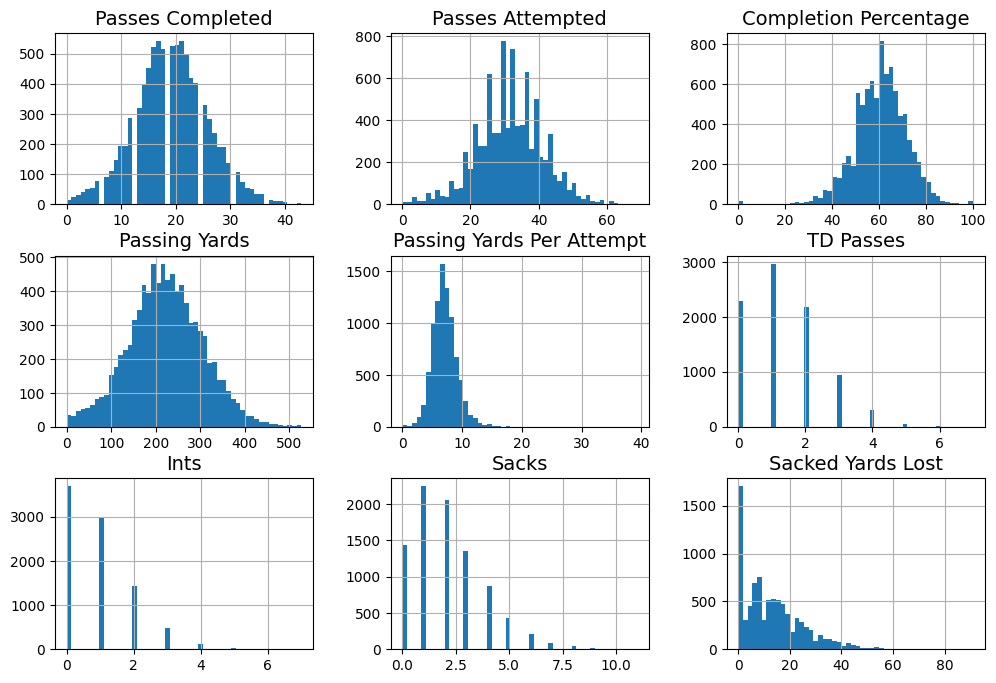

In [10]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

qb3[['Passes Completed','Passes Attempted','Completion Percentage','Passing Yards','Passing Yards Per Attempt','TD Passes','Ints','Sacks', 'Sacked Yards Lost']].hist(bins=50, figsize=(12, 8))

array([[<Axes: title={'center': 'Passer Rating'}>,
        <Axes: title={'center': 'Team Score'}>]], dtype=object)

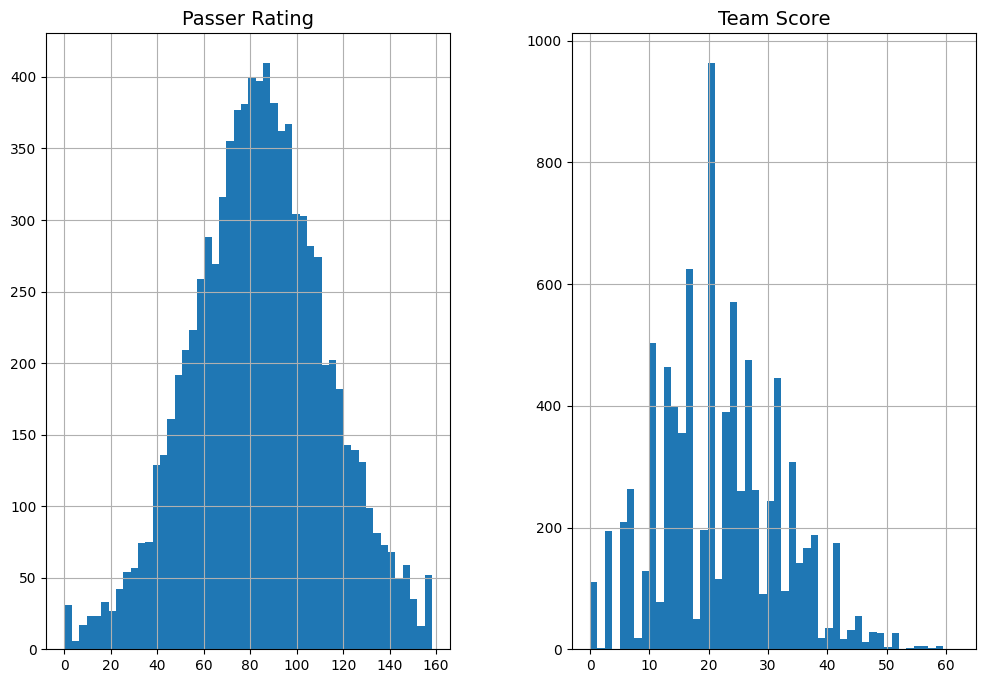

In [11]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

qb3[['Passer Rating','Team Score']].hist(bins=50, figsize=(12, 8))

array([[<Axes: title={'center': 'Rushing Attempts'}>,
        <Axes: title={'center': 'Rushing Yards'}>],
       [<Axes: title={'center': 'Yards Per Carry'}>,
        <Axes: title={'center': 'Rushing TDs'}>],
       [<Axes: title={'center': 'Fumbles'}>,
        <Axes: title={'center': 'Fumbles Lost'}>]], dtype=object)

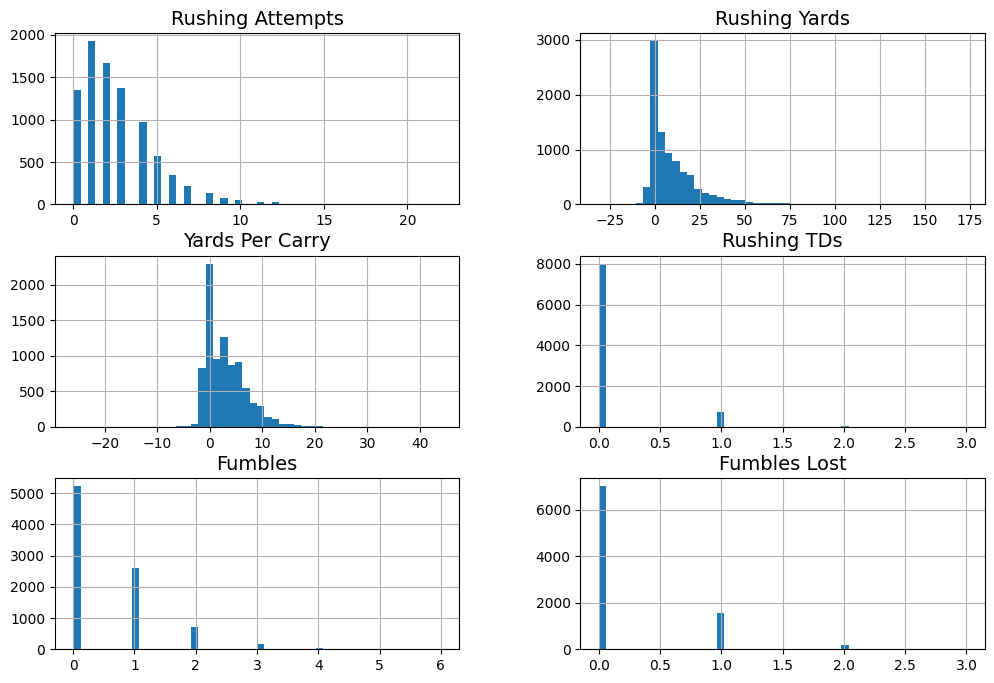

In [12]:
# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

qb3[['Rushing Attempts', 'Rushing Yards', 'Yards Per Carry', 'Rushing TDs', 'Fumbles','Fumbles Lost']].hist(bins=50, figsize=(12, 8))

In [13]:
qbyears = qb3.groupby(['Name','Year']).agg({'Ints' : 'sum', 'Passer Rating' : 'mean',
                                                              'TD Passes' : 'sum', 'Passes Completed' : 'sum',
                                                             'Passing Yards' : 'sum',
                                                           'Team Score' : 'mean',
                                                           'Passes Attempted' : 'sum',
                                                           'Completion Percentage' : 'mean'})

In [14]:
qbyears

Ints  Passer Rating  TD Passes  Passes Completed  \
Name         Year                                                     
Aikman, Troy 1991    10      85.058333         11               237   
             1992    14      90.025000         23               302   
             1993     6     103.728571         15               271   
             1994    12      89.985714         13               233   
             1995     7      93.312500         16               280   
...                 ...            ...        ...               ...   
Zeier, Eric  1998     2      78.700000          1                65   
             1999     0      81.200000          0                29   
Zolak, Scott 1992     3      66.525000          2                41   
             1995     0      77.300000          1                24   
             1998     2      65.700000          3                28   

                   Passing Yards  Team Score  Passes Attempted  \
Name         Year                                                
Aikman, Troy 1991           2754   20.250000               363   
             1992           3445   25.562500               473   
             1993           3100   24.428571               392   
             1994           2676   24.357143               361   
             1995           3304   27.187500               432   
...                          ...         ...               ...   
Zeier, Eric  1998            710   13.750000               109   
             1999            256    3.000000                44   
Zolak, Scott 1992            486   20.250000                71   
             1995            252   17.000000                45   
             1998            332   17.000000                61   

                   Completion Percentage  
Name         Year                         
Aikman, Troy 1991              64.800000  
             1992              64.256250  
             1993              70.221429  
             1994              65.414286  
             1995              65.781250  
...                                  ...  
Zeier, Eric  1998              59.825000  
             1999              65.900000  
Zolak, Scott 1992              54.775000  
             1995              53.300000  
             1998              45.950000  

[931 rows x 8 columns]

In [15]:
qbyear_averages = qbyears.groupby('Year').agg({'Passer Rating' : 'mean', 'Passes Completed': 'mean',
                                               'TD Passes' : 'mean', 'Ints' : 'mean', 'Passing Yards' : 'mean',
                                               'Team Score' : 'mean',
                                               'Passes Attempted' : 'mean',
                                               'Completion Percentage' : 'mean'
                                               })
qbyear_averages.head()

,Passer Rating,Passes Completed,TD Passes,Ints,Passing Yards,Team Score,Passes Attempted,Completion Percentage
Year,,,,,,,,
1991,69.477633,156.300000,9.366667,9.066667,1860.300000,17.258954,271.800000,54.808528
1992,71.811099,134.029412,9.088235,9.088235,1605.441176,17.743142,231.764706,55.362532
1993,72.723252,131.741935,7.967742,6.967742,1529.612903,17.238857,222.645161,54.517565
1994,76.745163,157.413793,10.482759,7.758621,1804.241379,19.530318,261.103448,57.393540
1995,77.423004,190.086957,13.000000,8.956522,2224.130435,21.014945,315.565217,59.262680


<ipython-input-16-dbee31077dc2>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Axes: xlabel='Year'>

<Figure size 800x550 with 0 Axes>

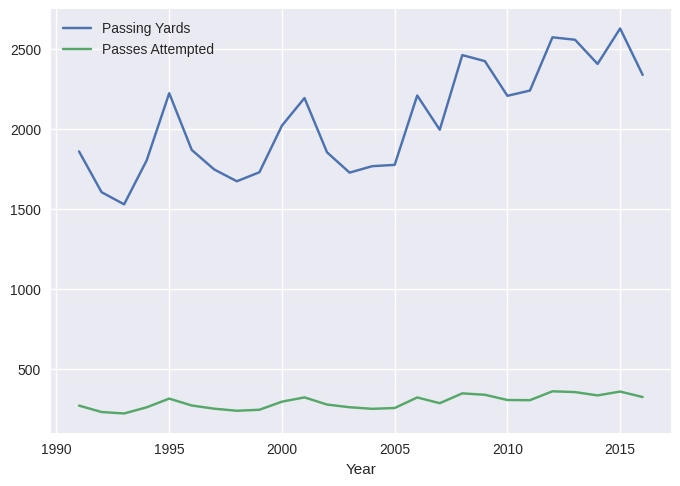

In [16]:
plt.style.use('seaborn')
line_chart_yds_vs_att = plt.figure()
line_chart_yds_vs_att = qbyear_averages[['Passing Yards', 'Passes Attempted']].plot()
line_chart_yds_vs_att

In [17]:
corr_matrix = qb3.corr()
corr_matrix["Passing Yards"].sort_values(ascending=False)

<ipython-input-17-7fba60c8cabb>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = qb3.corr()


Passing Yards                1.000000
Passes Completed             0.833275
Passes Attempted             0.737625
Passing Yards Per Attempt    0.571227
TD Passes                    0.525271
Passer Rating                0.473375
Completion Percentage        0.415096
Team Score                   0.389723
Year                         0.189997
Ints                         0.067818
Fumbles Lost                 0.035959
Rushing TDs                  0.033897
Fumbles                      0.019690
Sacked Yards Lost            0.016906
Sacks                        0.009680
Rushing Attempts             0.002908
Yards Per Carry             -0.013307
Rushing Yards               -0.025540
Week                        -0.065946
Name: Passing Yards, dtype: float64

# 1.3 Data preperation

In [18]:
qb3 = pd.get_dummies(qb3, columns=['Home or Away'])

qb3 = pd.get_dummies(qb3, columns =['Outcome'])

In [19]:
def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [20]:
train_set, test_set = shuffle_and_split_data(qb3, 0.2)
len(train_set)

7012

In [21]:
np.random.seed(42)

In [22]:
#Determine if a given identifier is in the test set
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

#Split a dataset into training and test sets based on hash of IDs
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [23]:
qb3_with_id = qb3.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(qb3_with_id, 0.2, "index")

In [24]:
train_set, test_set = train_test_split(qb3, test_size=0.2, random_state=42)

# 1.4 Modelling Random Forest Regressor

In [25]:
X = qb3.drop(['Passing Yards','Name','Season','Opponent','Score','Games Started'],axis = 1)
X

,Year,Week,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards Per Attempt,TD Passes,Ints,Sacks,Sacked Yards Lost,...,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost,Team Score,Home or Away_Away,Home or Away_Home,Outcome_L,Outcome_T,Outcome_W
48,2016,16,18,29,62.1,6.1,0,0,4,21,...,11.0,0,0,0,12,0,1,0,0,1
49,2016,17,5,8,62.5,3.1,0,0,1,15,...,0.5,0,1,1,17,1,0,1,0,0
80,2005,6,11,28,39.3,5.5,1,3,2,9,...,5.0,0,1,1,17,0,1,1,0,0
85,2005,11,19,36,52.8,6.4,1,1,6,34,...,2.8,0,1,1,13,1,0,1,0,0
96,2004,1,13,22,59.1,6.5,0,0,2,12,...,4.3,0,2,1,24,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40085,2015,13,16,26,61.5,6.4,1,1,1,7,...,0.3,0,0,0,17,1,0,0,0,1
40086,2015,14,35,51,68.6,6.0,0,0,5,32,...,3.3,0,1,0,12,0,1,1,0,0
40087,2015,15,21,44,47.7,6.7,3,1,2,15,...,3.8,1,2,0,27,1,0,1,0,0
40088,2015,16,27,39,69.2,7.7,1,0,3,22,...,1.7,0,0,0,20,0,1,0,0,1


In [26]:
scaler=StandardScaler()
scaled_X = scaler.fit_transform(X)

In [27]:
y = qb3['Passing Yards']
y

48       176
49        25
80       154
85       230
96       142
        ... 
40085    166
40086    308
40087    296
40088    299
40089    232
Name: Passing Yards, Length: 8765, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state = 42)

In [29]:
random_forest = RandomForestRegressor( n_estimators = 100,max_features = 10,random_state = 42)

qb_model = random_forest.fit(X_train,y_train)
y_test_pred = qb_model.predict(X_test)

# 1.5 Model Evaluation Random Forest Regressor

In [30]:
qb_rf_mse = mean_squared_error(y_test, y_test_pred)
qb_rf_mse

51.13735396463207

<Axes: >

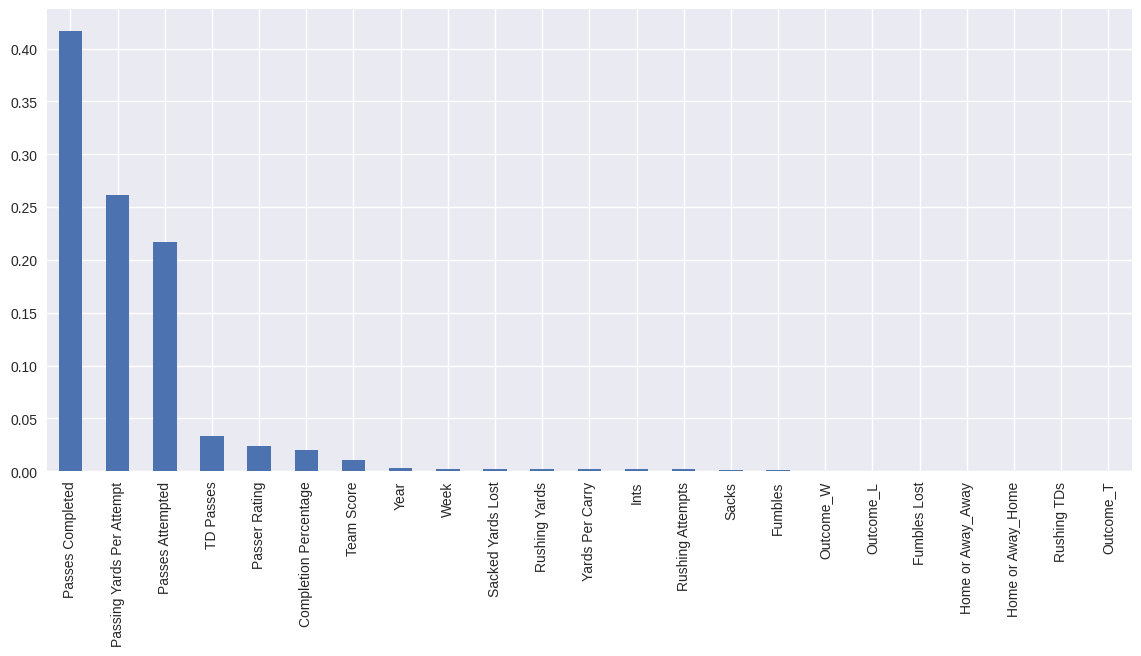

In [31]:
# Print feature importance
pd.Series(qb_model.feature_importances_,index = X.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (14,6))

In [32]:
#data frame of the feature importance of each predictor in acsending order
predictors = pd.DataFrame(list(zip(X.columns,qb_model.feature_importances_)),columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)
predictors

,predictor,feature importance
2,Passes Completed,0.416466
5,Passing Yards Per Attempt,0.261372
3,Passes Attempted,0.216746
6,TD Passes,0.032886
10,Passer Rating,0.023455
4,Completion Percentage,0.020006
17,Team Score,0.010293
0,Year,0.002906
1,Week,0.002113
9,Sacked Yards Lost,0.002024


# 1.6 Linear Regression

In [33]:
lm = LinearRegression()

lm_qb_model = lm.fit(X_train,y_train)

y_test_pred_lm = lm_qb_model.predict(X_test)

In [34]:
lm_qb_model.coef_

array([ 4.20498476e-02, -3.13640495e-01,  6.70241407e+01,  6.55149718e+00,
       -2.83047781e+01,  5.17974191e+01,  4.19938492e+00, -1.92844478e+00,
        3.92859981e-01,  3.35117126e-01, -4.54562167e+00,  2.36959290e-01,
       -3.99034639e-01, -1.33087543e-01,  1.16160202e-01,  2.64345882e-02,
        2.37757134e-01,  2.94238453e+00,  4.42852615e-02, -4.42852615e-02,
        3.08678922e-01,  2.88193438e-01, -3.29976572e-01])

# 1.7 Linear Regression model evaluation

In [35]:
lm_mse = mean_squared_error(y_test, y_test_pred_lm)
lm_mse

272.4529590603757

# 1.8 Model Selection

 We select the random forest model as it had a lower MSE than the linear regression model, we will drop features with feature importances under .0001 as they will not have a large impact on the predictions

In [36]:
X = qb3.drop(['Passing Yards','Name','Season','Opponent','Score','Games Started','Fumbles',
             'Outcome_W', 'Outcome_L', 'Fumbles Lost','Home or Away_Away','Home or Away_Home', 'Rushing TDs','Outcome_T'],axis = 1)

X

,Year,Week,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards Per Attempt,TD Passes,Ints,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Team Score
48,2016,16,18,29,62.1,6.1,0,0,4,21,79.1,1,11,11.0,12
49,2016,17,5,8,62.5,3.1,0,0,1,15,67.2,2,1,0.5,17
80,2005,6,11,28,39.3,5.5,1,3,2,9,30.1,3,15,5.0,17
85,2005,11,19,36,52.8,6.4,1,1,6,34,70.4,4,11,2.8,13
96,2004,1,13,22,59.1,6.5,0,0,2,12,78.2,3,13,4.3,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40085,2015,13,16,26,61.5,6.4,1,1,1,7,76.8,3,1,0.3,17
40086,2015,14,35,51,68.6,6.0,0,0,5,32,84.4,3,10,3.3,12
40087,2015,15,21,44,47.7,6.7,3,1,2,15,83.1,5,19,3.8,27
40088,2015,16,27,39,69.2,7.7,1,0,3,22,100.3,3,5,1.7,20


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [38]:
qb_model_final = random_forest.fit(X_train,y_train)
y_test_pred = qb_model_final.predict(X_test)

In [39]:
qb_rf_final_mse = mean_squared_error(y_test, y_test_pred)
qb_rf_final_mse

24.778340387906443

# 2.0 Solution Presentation - Results

# 2.1 Explainability of results

The features that used to predict a quarterback passing yards were fairly explainable in their ability to impact the total yards. Passes completed, passing yards per attempt and passes attempted were the strongest features and this has logical reasoning, as you complete more passes you gain more yards, if you average a higher amount of yards on your passes you will gain more yards and the more you attempt the more likely you are to complete a pass.

In [40]:
predictors = pd.DataFrame(list(zip(X.columns,qb_model_final.feature_importances_)),columns = ['predictor','feature importance']).sort_values(by='feature importance', ascending=False)

predictors

,predictor,feature importance
2,Passes Completed,0.475998
5,Passing Yards Per Attempt,0.278015
3,Passes Attempted,0.212005
10,Passer Rating,0.010990
4,Completion Percentage,0.007686
6,TD Passes,0.006398
14,Team Score,0.002726
0,Year,0.001045
1,Week,0.000975
9,Sacked Yards Lost,0.000897


#  2.2 Threats to Validity

A threat to validity would be data leakage, as for the predictions actual totals were used from each game. In a realtime prediction these statistics would not be known, which threatens the validity of the model.

# 2.3 Conclusions

In this problem I have learned the key features that affect the total yardage, to no suprise passes completed, passing yards per attempt and passes attempted were very strong features. However an interesting result was that turnovers(fumbles and Int's) had little impact on the total passing yards for the game. I would have though that turning the ball over to the other team would have a greater impact. In addition one more revalation was that the outcome of the game was one of the weakest features in the model, my hypothesis was that the winning team would have more passing yards but that was not the case.

# 2.4 Lessons Learned and next steps

Some lessons learned would be to use season averages to attempt to predict the total yardage of each game, with the models I have created I would have a fair idea of what the strongest features would be based on a quarterbacks previous performance.

Next steps would be to examine play by play data and defensive ranking data for a more realtime prediction. Things that could be examined are the strength of the passing defence,the formation of the defence and the overall strategy including wether or not the defence is blitzing the quarterback.